In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import os
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import haiku as hk
import functools
from deeprte.config import get_config
from deeprte.model.modules import DeepRTE
from deeprte.model.tf.input_pipeline import load_tf_data
from deeprte.model.data import flat_params_to_haiku

from deeprte.model.tf.rte_features import BATCH_FEATURE_NAMES

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def slice_batch(i: int, feat: dict):
    return {
        k: feat[k][i:i+1] if k in BATCH_FEATURE_NAMES else feat[k] for k in feat
    }

rng = hk.PRNGSequence(jax.random.PRNGKey(42))

In [4]:
config = get_config()
config = config.experiment_kwargs.config
# config.model.green_function.scattering.res_block_depth = 2

In [57]:
source_dir = "/workspaces/deeprte/rte_data/matlab/eval-data/scattering-kernel/0311"
# source_dir = "/workspaces/deeprte/rte_data/matlab/train-scattering-kernel-0309"
data_name_list = ["test_deltax_fixsk_v1.mat"]
# data_name_list = ["train_random_kernel_1.mat"]
# data_name_list = ["test_sin.mat"]
# data_name_list = ["test_bc1.mat"]

PARAMS_FILE = "/workspaces/deeprte/ckpts/train_scattering_kernel_2023-03-28T04:14:34/models/latest/step_570000_2023-03-30T05:30:18/params.npz"
# PARAMS_FILE = "/workspaces/deeprte/ckpts/train_scattering_kernel_2023-03-09T07:12:20/models/latest/step_555000_2023-03-11T06:44:08/params.npz"
CONFIG_PATH = "/workspaces/deeprte/ckpts/train_scattering_kernel_2023-03-09T07:12:20/config.json"

In [58]:
from deeprte.data.pipeline import DataPipeline

data_pipeline = DataPipeline(source_dir, data_name_list)

data = data_pipeline.process(
    pre_shuffle=False,
    pre_shuffle_seed=0,
    is_split_test_samples=False,
    num_test_samples=None,
    normalization=False,
    save_path=None,
)

In [59]:
tf_data = load_tf_data(source_dir, data_name_list, normalization=False)
features = jax.tree_map(lambda x: jnp.array(x), tf_data)
jax.tree_util.tree_map(lambda x: x.shape, features)

({'boundary': (10, 1920),
  'boundary_coords': (1920, 4),
  'boundary_scattering_kernel': (10, 1920, 24),
  'boundary_weights': (1920,),
  'phase_coords': (38400, 4),
  'position_coords': (1600, 2),
  'psi_label': (10, 38400),
  'scattering_kernel': (10, 38400, 24),
  'self_scattering_kernel': (10, 24, 24),
  'sigma': (10, 1600, 2),
  'velocity_coords': (24, 2),
  'velocity_weights': (24,)},
 {})

In [60]:
np_params = np.load(PARAMS_FILE)
params = flat_params_to_haiku(np_params)
jax.tree_util.tree_map(lambda x: x.shape, params)

{'deeprte/green_function/attenuation/attention_v2/key': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attention_v2/output_projection': {'b': (2,),
  'w': (64, 2)},
 'deeprte/green_function/attenuation/attention_v2/query': {'b': (64,),
  'w': (4, 64)},
 'deeprte/green_function/attenuation/attention_v2/value': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attenuation_linear': {'b': (128,),
  'w': (10, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_1': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_2': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/output_projection': {'b': (16,),
  'w': (128, 16)},
 'deeprte/green_function/output_projection': {'w': (16, 1)},
 'deeprte/green_function/scattering_module/__layer_stack_no_per_layer/scattering_layer/linear': {'b': (2,
   16),
  'w': (2, 16, 16)}}

In [61]:
def forward_fn(batch):
    out = DeepRTE(config.model)(batch, is_training=False, compute_loss=False, compute_metrics=False)
    return out

forward = hk.transform(forward_fn)
apply = jax.jit(forward.apply)
# init = jax.jit(functools.partial(forward.init, is_training = True))

In [71]:
# idx = np.random.randint(41*12)
idx_list = [2,3,4,5]

In [72]:
data_feature = features[0]

batches = []
for idx in idx_list:
    batch = slice_batch(idx, data_feature)
    batches.append(batch)

In [73]:
feat_list = ["boundary", "psi_label"]
batch = {}
for k in batches[0].keys():
    if k not in feat_list:
        batch[k] = batches[0][k]
    else:
        batch[k] = np.sum([b[k] for b in batches],axis=0)

batches.append(batch)

In [74]:
batch.keys()
# np.allclose(batch["boundary"],batches[0]["boundary"]+batches[1]["boundary"])

dict_keys(['boundary', 'boundary_coords', 'boundary_scattering_kernel', 'boundary_weights', 'phase_coords', 'position_coords', 'psi_label', 'scattering_kernel', 'self_scattering_kernel', 'sigma', 'velocity_coords', 'velocity_weights'])

In [75]:
psi_pres = []
psi_labels = []
phi_pres = []
phi_labels = []
for batch in batches[-1:]:
    batch["boundary"] = batch["boundary"].astype(np.float32)
    phase_coords = batch["phase_coords"].reshape((40,40,24,4))
    phi_label = jnp.dot(batch["psi_label"].reshape(40,40,24),batch["velocity_weights"])
    phi_labels.append(phi_label)
    psi_labels.append(batch["psi_label"].reshape(40,40,24))

    ret = apply(params, next(rng), batch)
    psi = ret["predicted_solution"]
    psi = psi*0.11769425123929977/0.13641896843910217
    psi_pres.append(psi.reshape(40,40,24))
    phi_pre = jnp.dot(psi.reshape(40,40,24),batch["velocity_weights"])
    phi_pres.append(phi_pre)

In [76]:
print(idx_list)

[2, 3, 4, 5]


In [77]:
for i in range(len(psi_pres)):
    phi_pre = phi_pres[i]
    phi_label = phi_labels[i]
    print(jnp.sqrt(jnp.mean((phi_label - phi_pre)**2)/jnp.mean(phi_label**2)))

0.03791138


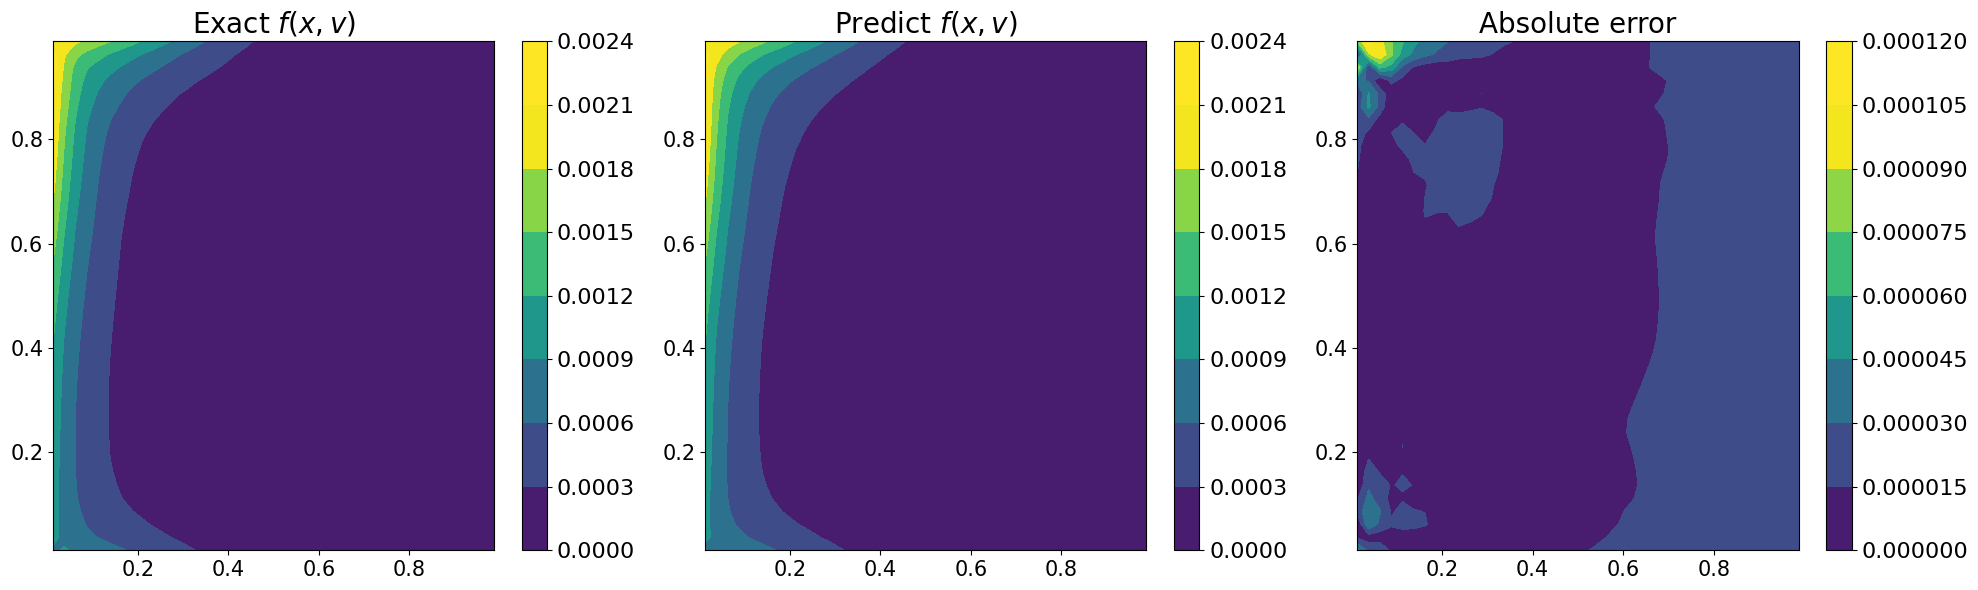

rmse: 0.03804746


In [78]:
i = -1

# idx = idx_list[i]
# print("idx:",idx)
phi_pre = phi_pres[i]
phi_label = phi_labels[i]

from notebooks.test.utils import plot_phi
r = batch['position_coords'].reshape(40,40,2)
plot_phi(r, phi_label, phi_pre)

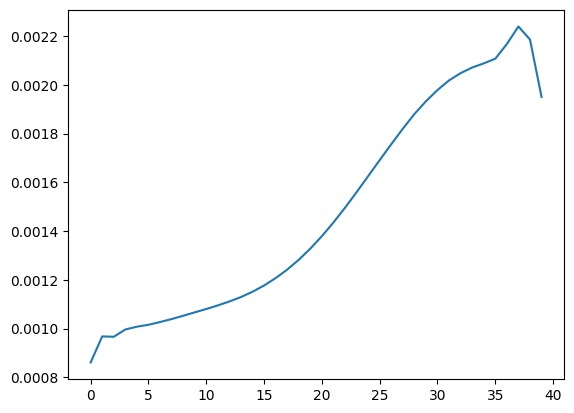

In [79]:
import matplotlib.pyplot as plt
plt.plot(phi_pre[0,:])